## Fashion-MNIST dataset classification

In [1]:
# necessary packages
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
import matplotlib.pyplot as plt

# additional packages
import random

c:\Users\shuang07\.conda\envs\auto_labeling\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download dataset

ground truth =  T-shirt/top
Dataset size =  60000


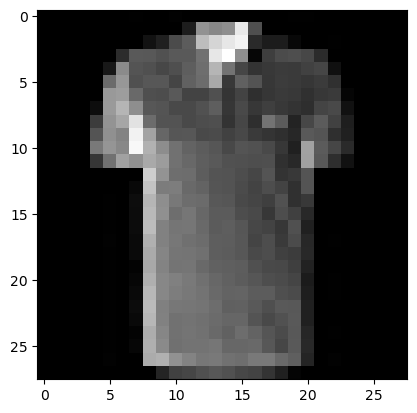

In [2]:
# get training dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# get testing dataset
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# class names
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# print random item to visualize
rand = random.randint(0, 59999)
img = training_data.__getitem__(rand)[0].reshape(28,28)
plt.imshow(img, cmap='gray')
print("ground truth = ", classes[training_data.__getitem__(rand)[1]])

# print dataset size 
size = len(training_data)
print("Dataset size = ", size)

### Create dataloader

In [3]:
# setup batchsize
batch_size = 64

# create dataloader (iterable)
training_dataloader = DataLoader(training_data, batch_size=batch_size)
testing_dataloader = DataLoader(testing_data, batch_size=batch_size)

# visualize the shape
for X, y in testing_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape)
    print("Data type of y: ", y.dtype)
    print(y)    # need to transfer [64] to [64, 10] by one-hot coding
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64])
Data type of y:  torch.int64
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


In [4]:
# testing block
print(len(training_dataloader.dataset))

60000


### Define Neural Network

In [5]:
# apply CUDA
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
print("device = ", device)

device =  cpu


In [6]:
# define basic model
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        score = self.linear(x)
        return score

In [7]:
basic_model = NeuralNetwork().to(device=device)
print(basic_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Model setup

In [8]:
# define parameters
learning_rate = 1e-3

# define lose function
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(basic_model.parameters(), lr=learning_rate)

In [9]:
# define functions 
def train(model, dataloader, loss_fn, optimizer):   # put epoch in main better for loss calculation
    # size of dataset
    size = len(dataloader.dataset)
    
    # set model mode
    model.train()
    
    # train batches per epoch
    for batch, (X, y) in enumerate(dataloader):
        # move data to device
        X, y = X.to(device), y.to(device)
        
        score = model(X)
        loss = loss_fn(score, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(model, dataloader, loss_fn):
    # size of dataset
    size = len(dataloader.dataset)
    
    # number of batches
    num_batches = len(dataloader)
    
    # set model mode
    model.eval()
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X,y in dataloader:
            # move data to device
            X, y = X.to(device), y.to(device)
            
            score = model(X)
            test_loss += loss_fn(score, y).item()
            correct += (score.argmax(1)==y).type(torch.float).sum().item()
    
    # calculate the average loss and accuracy
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Model training

In [12]:
# set epoch
epoch = 10

# start training
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(basic_model, training_dataloader, loss_fn, optimizer)
    test(basic_model, testing_dataloader, loss_fn)
print("Done!!")

# model saving
torch.save(basic_model.state_dict(), "model.pth")

Epoch 1
-------------------------------
loss: 0.579389  [    0/60000]
loss: 0.638553  [25600/60000]
loss: 0.684319  [51200/60000]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.639566 

Epoch 2
-------------------------------
loss: 0.564635  [    0/60000]
loss: 0.630887  [25600/60000]
loss: 0.676948  [51200/60000]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.629481 

Epoch 3
-------------------------------
loss: 0.550969  [    0/60000]
loss: 0.623907  [25600/60000]
loss: 0.670318  [51200/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.620018 

Epoch 4
-------------------------------
loss: 0.538249  [    0/60000]
loss: 0.617390  [25600/60000]
loss: 0.664360  [51200/60000]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.611136 

Epoch 5
-------------------------------
loss: 0.526399  [    0/60000]
loss: 0.611345  [25600/60000]
loss: 0.659284  [51200/60000]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.602797 

Epoch 6
-------------------------------
loss: 0.515315  [    0/60000]
loss: 0.605507  [256

### Model reloading

In [13]:
# load model
model_trained = NeuralNetwork()
model_trained.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Prediction

prediction："Trouser" / ground truth："Trouser"


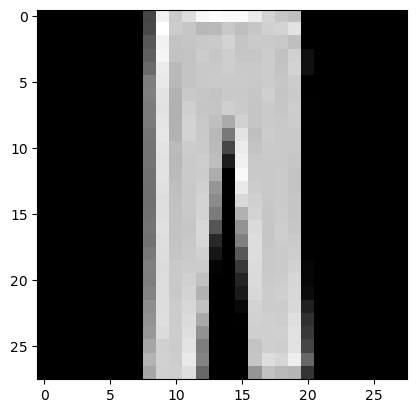

In [20]:
# class names
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# get random data from testing dataset
rand = random.randint(0, 9999)
x, y = testing_data[rand][0], testing_data[rand][1]

# switch mode
model_trained.eval()

with torch.no_grad():
    pred = model_trained(x)

    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'prediction："{predicted}" / ground truth："{actual}"')
    
# print random item to visualize
img = testing_data.__getitem__(rand)[0].reshape(28,28)
plt.imshow(img, cmap='gray')